In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle/house price/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle/house price/test.csv')

In [3]:
data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [4]:
data.shape

(1460, 81)

In [5]:
num_feats = data.dtypes[data.dtypes != 'object'].index
cat_feats = data.dtypes[data.dtypes == 'object'].index

print('수치형 변수: ', len(num_feats))
print('명목형 변수: ', len(cat_feats))

수치형 변수:  38
명목형 변수:  43


In [6]:
num_st = data[num_feats].corr().abs().nlargest(11, 'SalePrice')['SalePrice'].index
cat_st = ['MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual',
'BsmtQual', 'CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

In [7]:
all = pd.concat([data, test])
all.shape

(2919, 81)

In [8]:
allc = pd.concat([all[num_st], all[cat_st]], axis = 1)

In [9]:
allc.isna().sum().sort_values(ascending = False)

SalePrice       1459
BsmtQual          81
MasVnrType        24
MSZoning           4
KitchenQual        1
Electrical         1
SaleType           1
TotalBsmtSF        1
GarageArea         1
GarageCars         1
FullBath           0
TotRmsAbvGrd       0
YearBuilt          0
OverallQual        0
1stFlrSF           0
Neighborhood       0
Condition2         0
ExterQual          0
CentralAir         0
GrLivArea          0
YearRemodAdd       0
dtype: int64

* BsmtQual 'None' 처리

In [10]:
allc['BsmtQual'].fillna('None', inplace = True)

* OneHotEncoding

In [11]:
allc = pd.get_dummies(allc)

* 있다/없다

In [12]:
allc['GarageArea'] = allc['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
allc['TotalBsmtSF'] = allc['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

* GrLivArea 이상치 제거

In [13]:
tr = allc[:len(data)]
te = allc[len(data):]

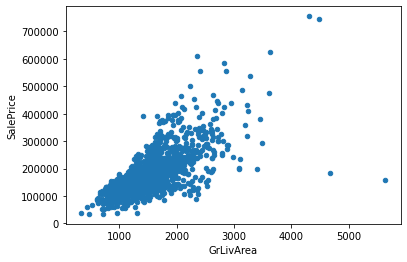

In [14]:
tr.plot.scatter(x = 'GrLivArea', y = 'SalePrice')

In [15]:
tr = tr.drop(tr[tr['GrLivArea'] >= 4500].index)

In [16]:
import numpy as np
from sklearn.model_selection import train_test_split

In [17]:
X = tr.drop('SalePrice', axis = 1)
y = np.log(tr['SalePrice'])

X_tr, X_vld, y_tr, y_vld = train_test_split(X, y,
                                         test_size = 0.2,
                                         random_state = 2000)

* xgboost

In [18]:
import xgboost
from sklearn.metrics import mean_squared_error

In [19]:
xgb = xgboost.XGBRegressor()
xgb.fit(X_tr, y_tr)
print(mean_squared_error(y_vld, xgb.predict(X_vld))**0.5)

[08:37:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.1498358127185642


* submission

In [21]:
sub = pd.DataFrame()
sub['ID'] = test['Id']
sub['SalePrice'] = np.exp(xgb.predict(te.drop('SalePrice', axis = 1)))

sub.to_csv('xgb.csv', index = False)